# **Data Preparation**

# **Importing Data & Creating Dataframe**

In [ ]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
#Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024383.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024381.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024358.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024412.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024324.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024312.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024337.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024338.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024336.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024408.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024382.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024371.jpg
/content/drive/MyDrive/Datasets/Test/Seborrheic Keratosis/ISIC_0024409.jpg
/content/drive/MyDrive/Da

In [ ]:
print(os.listdir("/content/drive/MyDrive/Datasets"))

['Test', 'Train']


In [ ]:
base_dir = '/content/drive/MyDrive/Datasets'
train_dir = "/content/drive/MyDrive/Datasets/Train"
test_dir = "/content/drive/MyDrive/Datasets/Test"

In [ ]:
# Create dataframes
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

# Add images paths and labels to dataframes
for label, directory in enumerate(os.listdir(train_dir)):
    for filename in os.listdir(os.path.join(train_dir, directory)):
        image_path = os.path.join(train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(test_dir)):
    for filename in os.listdir(os.path.join(test_dir, directory)):
        image_path = os.path.join(test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df

<ipython-input-6-a96052ccfec7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-6-a96052ccfec7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-6-a96052ccfec7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-6-a96052ccfec7>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 

In [ ]:
# Get list of directories in train_path
labels = os.listdir(train_dir)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'Seborrheic Keratosis',
 1: 'Vascular Lesion',
 2: 'Melanoma',
 3: 'Dermatofibroma',
 4: 'Basal Cell Carcinoma',
 5: 'Actinic Keratosis'}

# **Loading & Resizing of images**

In [ ]:
max_images_per_class = 2000

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

<ipython-input-8-35934e1bc810>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [ ]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [ ]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

2

In [ ]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((75,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

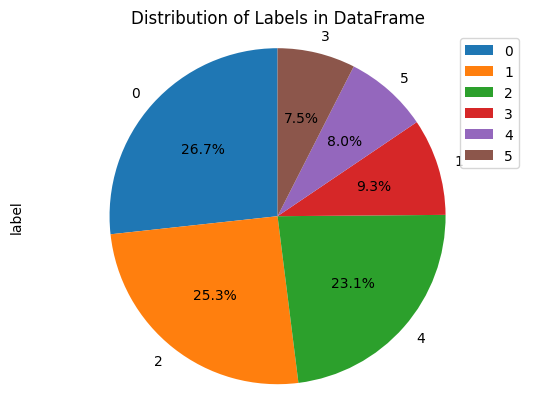

In [ ]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

# **Displaying Total Number before Data Augmentation**

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               Seborrheic Keratosis           478       
1               Vascular Lesion                167       
2               Melanoma                       452       
3               Dermatofibroma                 134       
4               Basal Cell Carcinoma           414       
5               Actinic Keratosis              144       
------------------------------------------------------------
Total                                         1789      


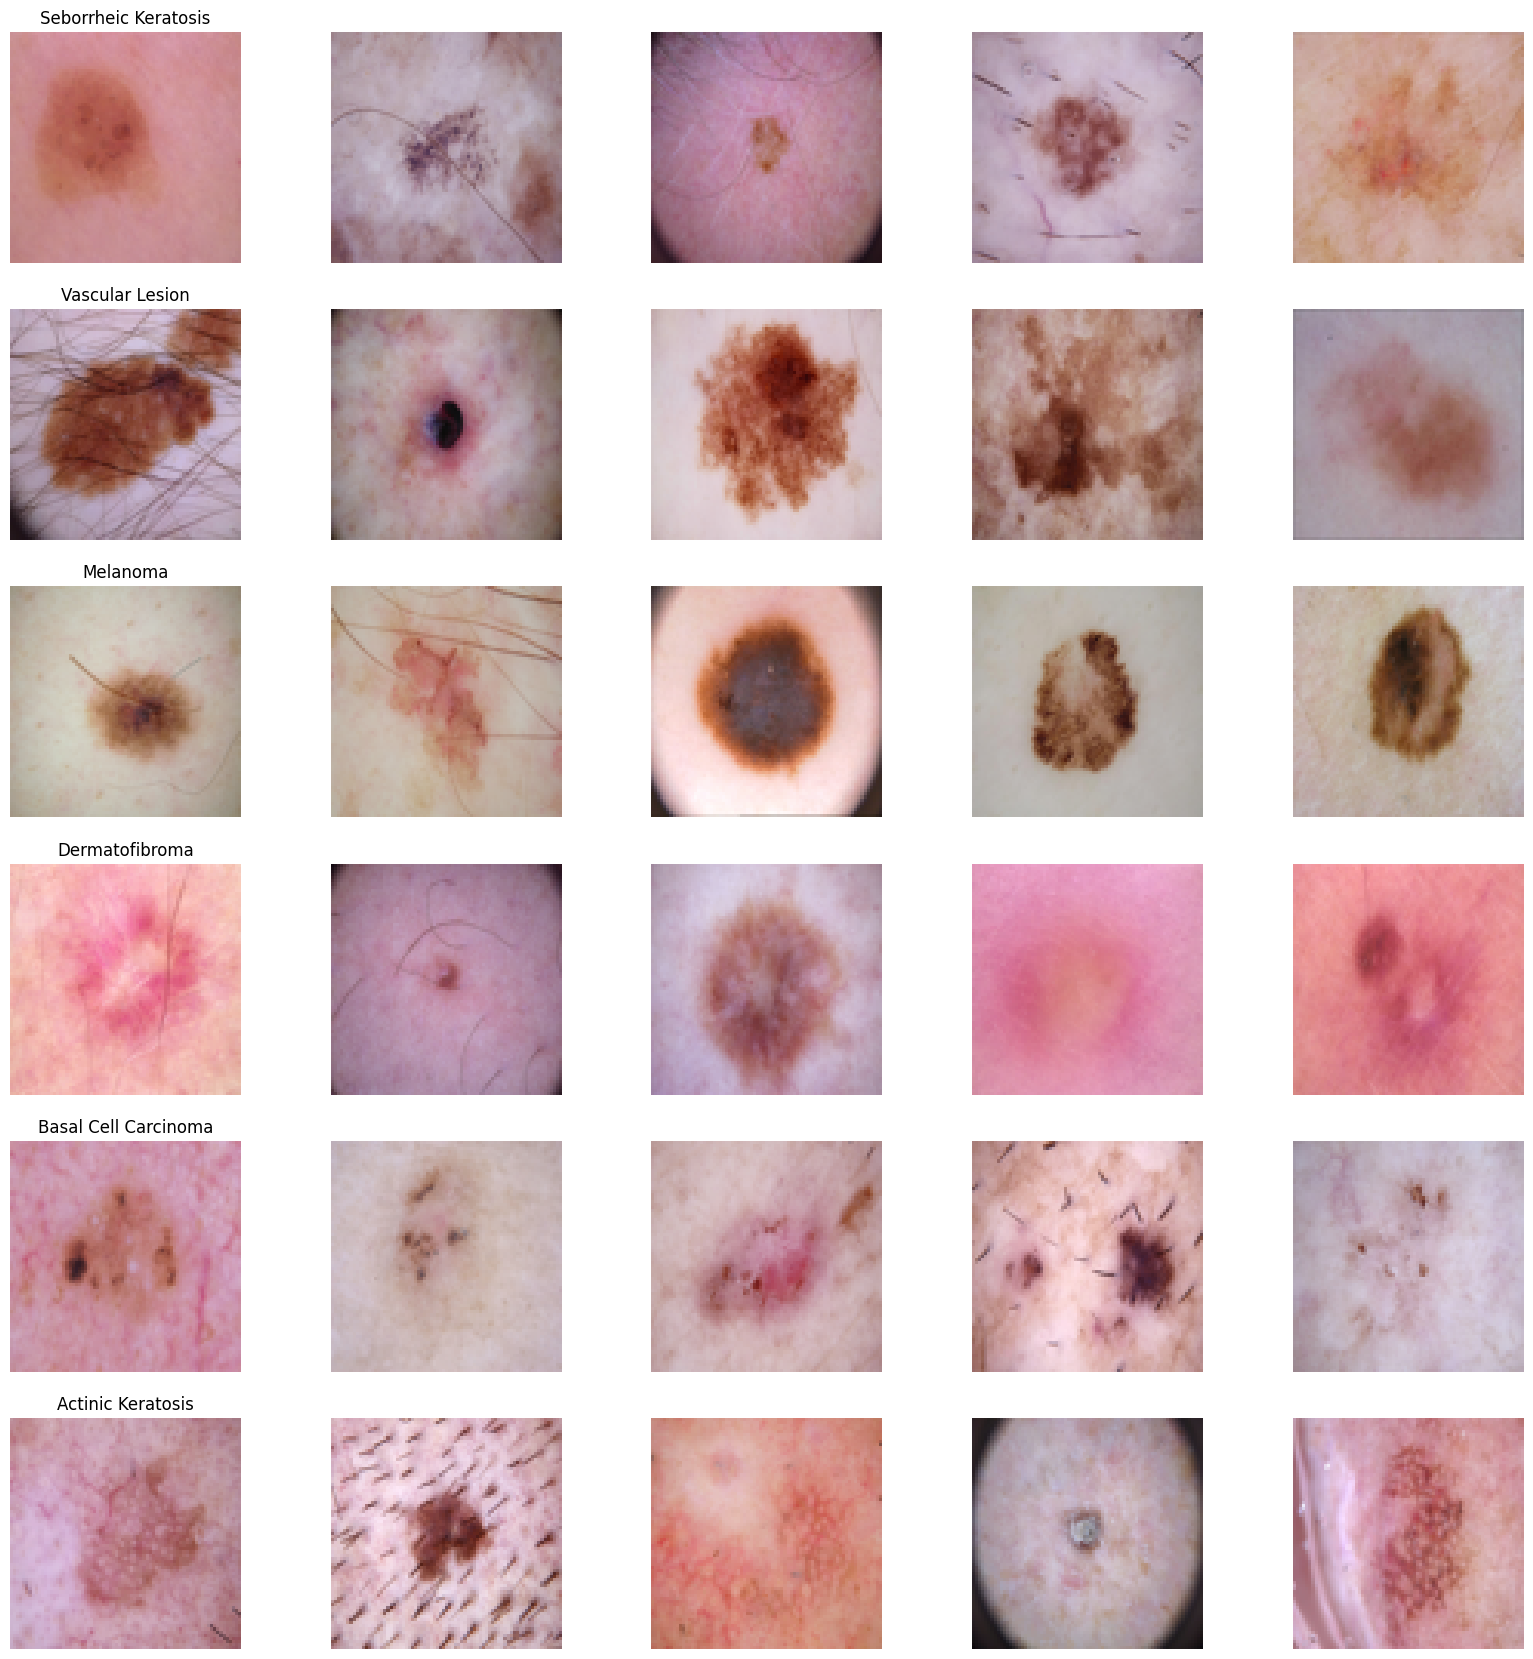

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(num_classes, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = label_map[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 75, 3)    1789
Name: image, dtype: int64

# **Data Augmentation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

In [ ]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
           # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)

            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)

    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df
# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
<ipython-input-17-10713e6576df>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_ce

In [ ]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               Seborrheic Keratosis           2000      
1               Vascular Lesion                2000      
2               Melanoma                       2000      
3               Dermatofibroma                 2000      
4               Basal Cell Carcinoma           2000      
5               Actinic Keratosis              2000      
------------------------------------------------------------
Total                                         12000     


# **Train & Test Split**

In [ ]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [ ]:
print(target.shape,features.shape)

(12000,) (12000, 1)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

# **Normalization of Data**

In [ ]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# **Label Encoding**

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = num_classes)
y_test = to_categorical(y_test,num_classes = num_classes)

# **Splitting data**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 75, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 75, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 75, 3))

In [ ]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

# **Displaying Total Number of Each Class**

In [ ]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in label_map.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               Seborrheic Keratosis           1301       312          387        2000      
1               Vascular Lesion                1304       317          379        2000      
2               Melanoma                       1263       347          390        2000      
3               Dermatofibroma                 1263       296          441        2000      
4               Basal Cell Carcinoma           1302       296          402        2000      
5               Actinic Keratosis              1247       352          401        2000      
------------------------------------------------------------------------------------------
Total                                          7680       19

In [ ]:
df.groupby('label').size()

label
0    2000
1    2000
2    2000
3    2000
4    2000
5    2000
dtype: int64

In [ ]:
input_shape = df['image'][0].shape

# **Model Architecture**

In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 7680)              0         
                                                                 
 dropout (Dropout)           (None, 7680)              0         
                                                                 
 dense (Dense)               (None, 512)               3932672   
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 22,257,734
Trainable params: 22,028,678
Non-trainable params: 229,056
_______________________________________

# **Setting Optimizer**

In [ ]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# **Fitting Model**

In [ ]:
# Fit the model
epochs = 20
batch_size=32
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/20
240/240 [==============================] - 1131s 5s/step - loss: 0.9040 - accuracy: 0.6905 - val_loss: 0.3770 - val_accuracy: 0.8724 - lr: 0.0010
Epoch 2/20
240/240 [==============================] - 1135s 5s/step - loss: 0.2678 - accuracy: 0.9089 - val_loss: 0.1421 - val_accuracy: 0.9557 - lr: 0.0010
Epoch 3/20
240/240 [==============================] - 1094s 5s/step - loss: 0.1232 - accuracy: 0.9590 - val_loss: 0.1269 - val_accuracy: 0.9542 - lr: 0.0010
Epoch 4/20
240/240 [==============================] - 1122s 5s/step - loss: 0.0776 - accuracy: 0.9719 - val_loss: 0.0971 - val_accuracy: 0.9693 - lr: 0.0010
Epoch 5/20
240/240 [==============================] - 1085s 5s/step - loss: 0.0640 - accuracy: 0.9789 - val_loss: 0.0695 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 6/20
240/240 [==============================] - 1123s 5s/step - loss: 0.0487 - accuracy: 0.9822 - val_loss: 0.0722 - val_accuracy: 0.9786 - lr: 0.0010
Epoch 7/20
240/240 [==============================] - 1121

# **Model Evaluation**

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

240/240 [==============================] - 168s 702ms/step - loss: 0.0013 - accuracy: 0.9995
Train: accuracy = 0.999479  ;  loss = 0.001343


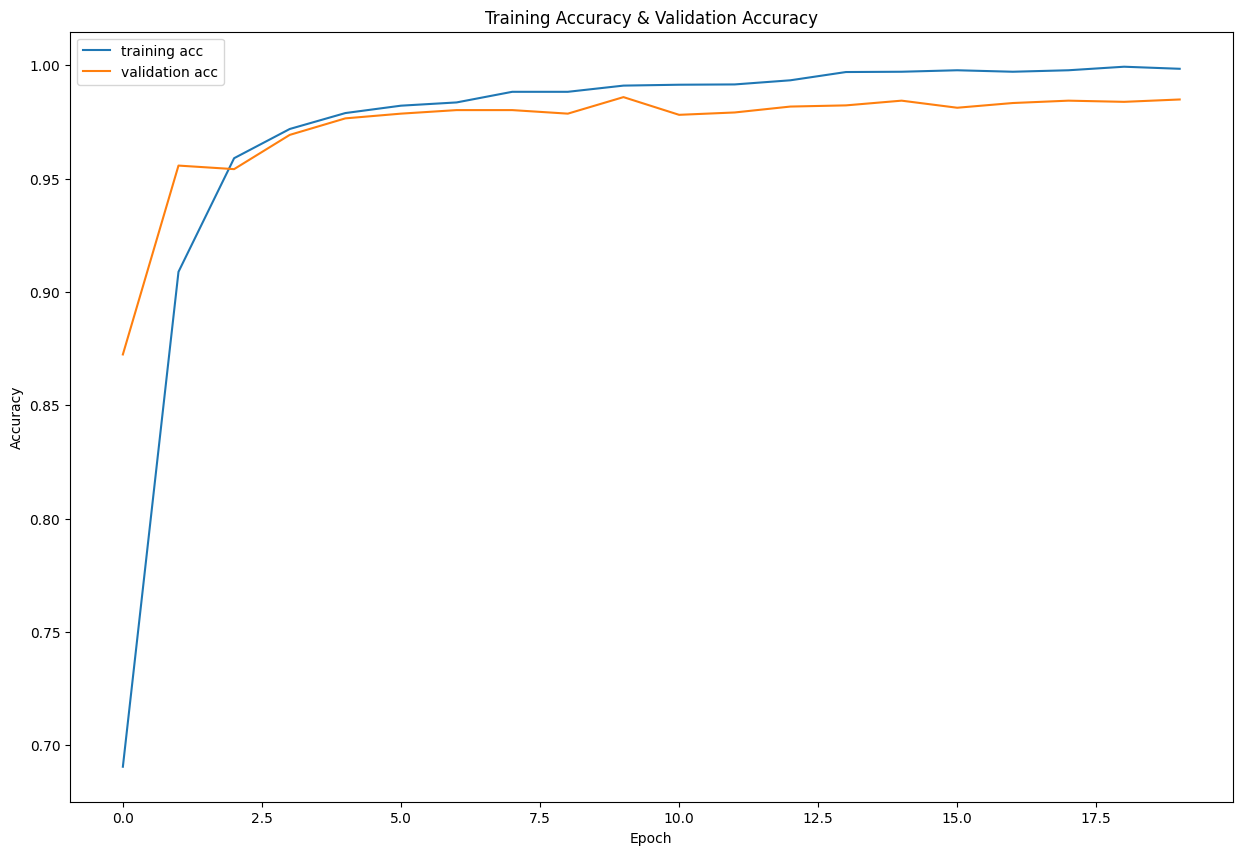

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history.history["accuracy"],label = "training acc")
plt.plot(history.history["val_accuracy"],label = "validation acc")
plt.title("Training Accuracy & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

75/75 [==============================] - 60s 719ms/step - loss: 0.0463 - accuracy: 0.9883
Testing: accuracy = 0.988333  ;  loss = 0.046306


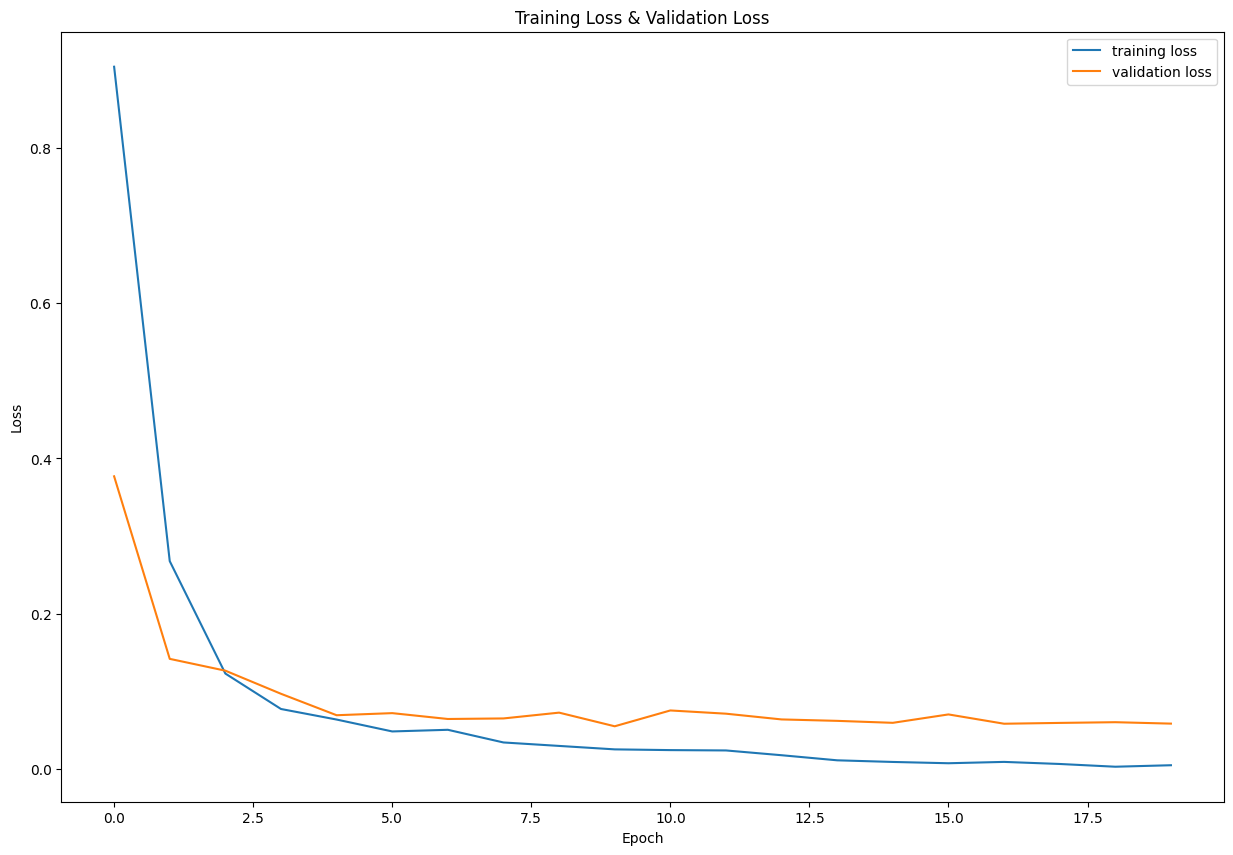

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(history.history["loss"],label = "training loss")
plt.plot(history.history["val_loss"],label = "validation loss")
plt.title("Training Loss & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

75/75 [==============================] - 57s 715ms/step
[[379   1   1   0   3   3]
 [  0 375   4   0   0   0]
 [  2   7 379   1   1   0]
 [  0   0   0 441   0   0]
 [  3   0   0   0 397   2]
 [  0   0   0   0   0 401]]


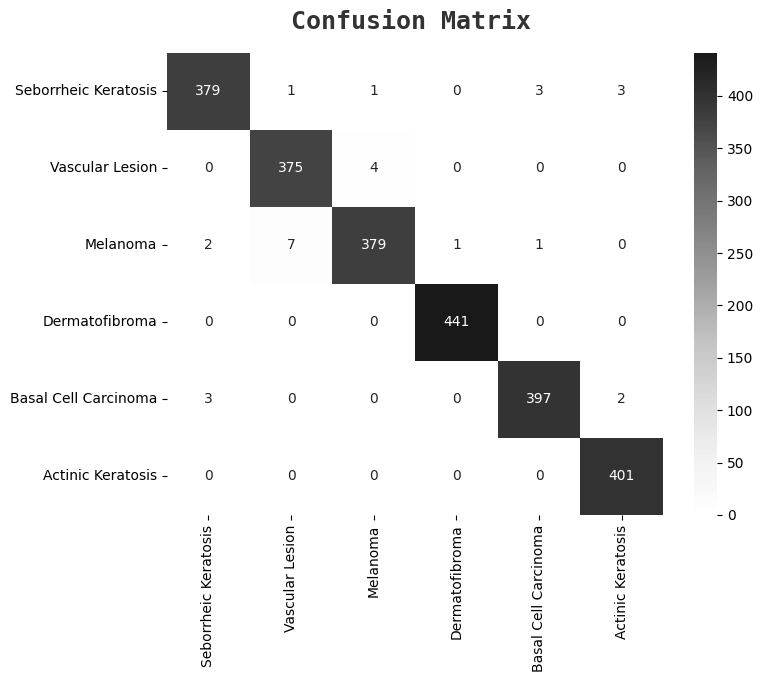

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
fig,ax=plt.subplots(1,1,figsize=(8,6))

sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_prob, axis=1)),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt="d",
            cmap='Greys',
            alpha=0.9,
            )

fig.text(s='Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         color ='black',
         y=0.92,
         x=0.28,
         alpha=0.8)
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_prob, axis=1)))
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       387
           1       0.98      0.99      0.98       379
           2       0.99      0.97      0.98       390
           3       1.00      1.00      1.00       441
           4       0.99      0.99      0.99       402
           5       0.99      1.00      0.99       401

    accuracy                           0.99      2400
   macro avg       0.99      0.99      0.99      2400
weighted avg       0.99      0.99      0.99      2400



# **Saving The Model**

In [ ]:
model.save("modeldensenetfix.h5")